# Variational Autoencoders in JAX

This notebook shows how to build a deep Variational Autoencoder (VAE) with JAX, trained on the MNIST dataset. The implementation is inspired by a lecture about generative ML at the University of Toronto.

A VAE is a kind of autoencoder that outputs a probability distribution in the latent space, unlike their (unvariational) counterpart that outputs a single latent vector instead. Our VAE encoder, instead of learning a good encoding vector in the latent space, gives the parameters of a multidimensional isotropic Gaussian that can be used to sample encodings from the latent space.

A quick recap on the inner workings. For an input $x_i$ and it's low-dimensional, latent representation $z$ we approximate the true posterior $p(z \vert x_i) \approx q_{\Phi_i}(z \vert x_i) = \mathcal{N}(\mu_i, \sigma_i^2)$ by a multidimensional isotropic Gaussian parametrized by $\Phi_i = (\mu_i, \log \sigma_i)$. This is our encoder. We decode a latent representation $p_\theta(x \vert z)$ parameterized by $\theta$.

Ideally, we would train the network as to maximize the data log probability $\log p(x)$. This is of course intractable; hence maximizing the Evidence Lower Bound (ELBO) serves as our objective placebo. Minimizing the negative ELBO, we get as a loss function:
\begin{align}
\mathcal{L}(\Phi, \theta; x) = -\mathbb{E}_{z \sim q_{\Phi}}{\left[\log p_\theta(x \vert z) \right]} + KL \left( q_\Phi(z \vert x) \vert \vert p(z) \right)
\end{align}
where the second term denotes our divergence of the assumed Gaussian $q_\Phi$ from the true prior $p(z)$.

Now let's define the model we use for MNIST encoding. Our prior $p(z) = \mathcal{N}(0, I)$ is assumed to be standard Gaussian. The likelihood $p_\theta(x \vert z) = \text{Bernoulli}(\theta)$ will be a multidimensional binomial where we have a bernoulli parameter for each pixel. The posterior approximation $q_{\Phi_i}(z \vert x_i) = \mathcal{N}(\mu_i, \sigma_i^2I)$ is an isotropic Gaussian.

Now in the classic implementation of a VAE, we have a set of parameters $\Phi_i$ for each datapoint, creating a dependency of the number of parameters to the training data size. To circumvent this, we use Amortized Inference (AI) to reduce the number of model parameters. The idea of AI is that instead of having $\Phi_i$ for each datapoint, we have a single $\Phi$ that specifies the parameters of a Neural Networks that, given $x_i$, outputs us $\Phi_i$. So we get $q_{\Phi_i}(z \vert x_i) = \mathcal{N}(z \vert \mu_{\Phi}(x_i), \Sigma_{\Phi}(x_i))$ instead.

JAX will provide us with the necessary autodiff functionality; we use Adam for gradient-based optimization of $\theta$ and $\Phi$.

## Part 1: Preparations

Let us import the necessary packages first.

In [1]:
from jax import jit, grad, value_and_grad, lax, vmap, random
import jax.numpy as np
import jax.random
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm
from jax.tree_util import register_pytree_node

from flax import linen as nn
import optax

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as dists

#rom jax.config import config 
#config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
from tqdm.auto import trange
from functools import partial
from random import randint   # simple python rnd
from random import randint   # simple python rnd

## Part 2: Data
First things first, get the data!

Each datapoint in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a 28x28 grayscale image (i.e. pixels are values between 0 and 1) of a handwritten digit in $\{0 \dots 9\}$, and a label indicating which number.

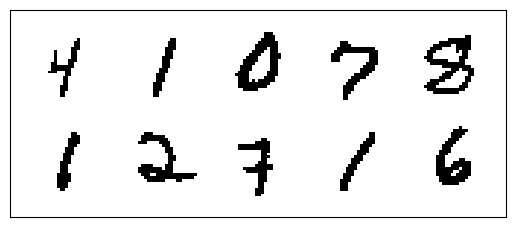

In [2]:
# Load MNIST data
import os
import gzip
import struct
import array
import matplotlib.image
from urllib.request import urlretrieve
import tensorflow_datasets as tfds

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    tfds_dataset, ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=False, as_supervised=True, with_info=True)
    train, test = tfds_dataset
    train_images, train_labels = [], []
    test_images, test_labels = [], []
    for image, label in tfds.as_numpy(train):
        train_images.append(image)
        train_labels.append(label)
    for image, label in tfds.as_numpy(test):
        test_images.append(image)
        test_labels.append(label)
    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

def load_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(np.array(x.shape[1:]))))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_mnist()

mean_image = np.mean(train_images, 0)


import numpy as onp   # original numpy
def plot_images(images, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = onp.int32(onp.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = onp.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(onp.array([]))
        plt.yticks(onp.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])

## Part 3: Implement the VAE
Now that we have everything we need, we implement the Variational Autoencoder on binarized MNIST digits, as introduced by the paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013). 

At first, some generic VAE funtions:

In [3]:
# Generic VAE functions.

def log_prior(z): 
    return np.sum(norm.logpdf(z, 0.0, 1.0), axis=-1)

def diag_gaussian_sample(rng, mean, log_std): 
  return mean + np.exp(log_std) * random.normal(rng, mean.shape) # single sample from a diagonal multivariate Gaussian

def diag_gaussian_logpdf(x, mean, log_std):
  return np.sum(vmap(norm.logpdf)(x, mean, np.exp(log_std))) # evaluate a single point on a diagonal multivariate Gaussian

def elbo(  # Single-sample Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes recognition_params and a datapoint, outputs mean and log_std of size latent_dim, i.e. log q(z|x)
    log_joint,          # takes likelihood_params and a vector of size latent_dim and a datapoint, outputs unnormalized log joint, i.e. log p(x,z)
    recognition_params, # Phi
    model_params,       # theta
    datapoint, rng):

  q_params = recognition_net(recognition_params, datapoint)  # get the approximate posterior parameters for dp using amotized inference
  mu, log_standarddev = q_params
  sample = diag_gaussian_sample(rng, mean=mu, log_std=log_standarddev)  # sample from approximate posterior.
  log_joint_value = log_joint(model_params, sample, datapoint) 
  log_post_value = diag_gaussian_logpdf(sample, mean=mu, log_std=log_standarddev) # Evaluates the density of log posterior q(z).
  
  # KL-divergence between two multidim. Gaussians
  d_kl = 0.5*(np.sum(np.exp(log_standarddev)) + np.dot(mu, mu) - datapoint.shape[0] - np.sum(log_standarddev)) 
  elbo_hat = log_joint_value - d_kl 
  return elbo_hat

def batch_elbo(recognition_net, log_joint, recognition_params, model_params, data, rng):   # batched version using JAX's vmap
  batch_size = data.shape[0]
  rngs = random.split(rng, batch_size)
  vectorized_elbo = vmap(partial(elbo, recognition_net, log_joint,
                                 recognition_params, model_params),
                         in_axes=(0, 0))
  return np.mean(vectorized_elbo(data, rngs)) # average ELBO estimate over a batch of samples


In [4]:
mean_image.shape

(784,)

Here we set the dimension of the latent space to 2.
A larger latent dimension would provide a more powerful model, but a dimension of two will make visualization and debugging easier.

Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.

After each hundert iterations, we report the Evidence Lower Bound. 

In [5]:
# Define a VAE for the MNIST dataset

data_dimension = 28*28
latent_dimension =4
key = random.PRNGKey(0)

class RecognitionNet(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=150)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    mean = nn.Dense(features=latent_dimension)(x)   # Output mean of q(z)
    log_std = nn.Dense(features=latent_dimension)(x)   # Output log_std of q(z)
    return mean, log_std

class Decoder(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=150)(x)
    x = nn.gelu(x)
    x = nn.Dense(features=100)(x)
    x = nn.gelu(x)
    x = nn.Dense(features=data_dimension)(x)   # Output logit of Ber(x|z)
    return x

x_rand = random.normal(key, (data_dimension,))
z_rand = random.normal(key, (latent_dimension,))
init_recognition_params = RecognitionNet().init(key, x_rand)
init_decoder_params = Decoder().init(key, z_rand)

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))   # Bernoulli log pdf of data x given logits

def log_likelihood(decoder_params, latent, datapoint):
  logits = Decoder().apply(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_likelihood(decoder_params, latent, datapoint) + log_prior(latent)

# Run optimization
n_iters = 12000
minibatch_size = 200
optimizer = optax.adam(learning_rate=1e-3)
params = (init_recognition_params, init_decoder_params)
opt_state = optimizer.init(params)

@jax.jit
def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(key, train_images.shape[0], (minibatch_size,))
  minibatch =  train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(RecognitionNet().apply, log_joint, recognition_params, decoder_params, minibatch, rng) 
  
def callback(params, t):
  if t % 100 == 0:
    print(f"Iteration {t}: ELBO {-objective(params, t)}")
  
@jax.jit
def step(params, opt_state, rnd):   
    gradient = grad(objective)(params, rnd)  # rnd used for random key in objective
    updates, opt_state = optimizer.update(gradient, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    params, opt_state = step(params, opt_state, t)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/12000 [00:00<?, ?it/s]

Iteration 0: ELBO -161.88946533203125
Iteration 100: ELBO 199.61489868164062
Iteration 200: ELBO 237.6708526611328
Iteration 300: ELBO 260.3966064453125
Iteration 400: ELBO 275.1552734375
Iteration 500: ELBO 286.3271179199219
Iteration 600: ELBO 295.77508544921875
Iteration 700: ELBO 303.4945373535156
Iteration 800: ELBO 311.3873291015625
Iteration 900: ELBO 317.9194641113281
Iteration 1000: ELBO 323.6898193359375
Iteration 1100: ELBO 328.5906982421875
Iteration 1200: ELBO 333.32232666015625
Iteration 1300: ELBO 337.3663330078125
Iteration 1400: ELBO 340.7325439453125
Iteration 1500: ELBO 343.3464660644531
Iteration 1600: ELBO 346.2091979980469
Iteration 1700: ELBO 348.9212951660156
Iteration 1800: ELBO 351.5205383300781
Iteration 1900: ELBO 353.810302734375
Iteration 2000: ELBO 355.5611572265625
Iteration 2100: ELBO 357.2292175292969
Iteration 2200: ELBO 358.93115234375
Iteration 2300: ELBO 359.8404541015625
Iteration 2400: ELBO 361.2743225097656
Iteration 2500: ELBO 362.6004333496094

## Part 4: Investigate the Model

Great, model implementation and training has been completed! In what follows, we investigate our model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between digits.

One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data. Here we'll produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set.

What we do here:

1.   Encode each image in the training set.
2.   Take the 2D mean vector of each encoding $q_\phi(z|x)$.
3.   Plot these mean vectors in the 2D latent space with a scatterplot.
4.   Colour each point according to the class label (0 to 9).


Hopefully our latent space will group images of different classes, even though we never provided class labels to the model. The latent structure has been learned by the model!





(np.float64(-2.139634108543396),
 np.float64(2.0629262685775758),
 np.float64(-1.9332974672317504),
 np.float64(2.0333381414413454))

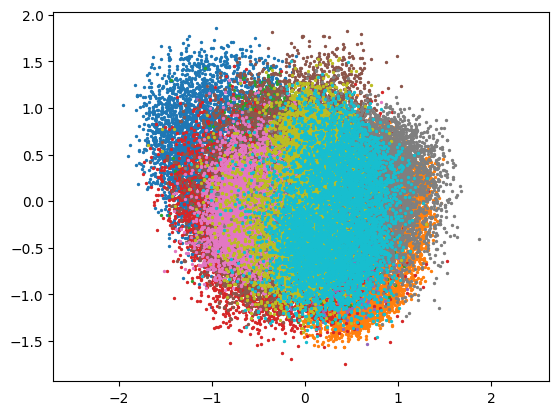

In [6]:
for k in range(10):
  cur_data = train_images[train_labels[:, k] == True, :]
  latent_mean, _ = RecognitionNet().apply(recognition_params, cur_data)
  plt.scatter(latent_mean[:, 0], latent_mean[:, 1], s=2)

plt.axis("equal")

But we can do more than that. A VAE is a generative model. We will generate some images by sampling from the prior in the latent space and decoding them to obtain artificial MNIST images.

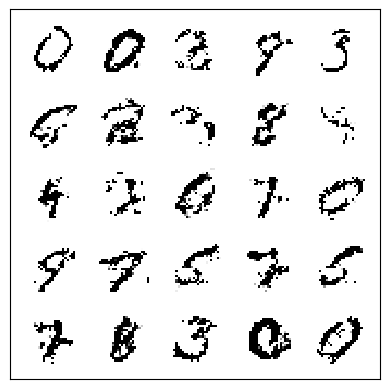

In [7]:
# Sample data from the trained generative model to see if it roughly matches the data.

def sigmoid(x):
  return 0.5 * (np.tanh(x) + 1.0)

recognition_params, decoder_params = params
n_samples = 25
sampled_zs = jax.random.normal(key, shape=(n_samples,latent_dimension)) # sample from prior on z.
vdecoder = vmap(Decoder().apply, in_axes=(None, 0))
bernoulli_means = sigmoid(vdecoder(decoder_params, sampled_zs)) # call decoder, and map logits to probabilities.
plot_images(bernoulli_means)

Another interesting way to examine a continuous latent variable model is to interpolate between the latent representations of two points. Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their latent representation. We will plot the generative distributions along the linear interpolation.


1.   We write a function which takes two points $z_a$ and $z_b$, and a value $\alpha \in [0,1]$, and outputs the linear interpolation $z_\alpha = \alpha z_a + (1-\alpha)z_b$.
2.  Then we sample 3 pairs of images, each having a different class.
3.  Afterwards we encode the images in each pair, take the mean vectors and linearly interpolate them
4.  At 10 equally-space points along the interpolation, we show the Bernoulli means $p(x|z_\alpha)$.

In [8]:
def plot_interp(ix1, ix2):
  left_z = RecognitionNet().apply(recognition_params, train_images[ix1, :])[0]
  right_z = RecognitionNet().apply(recognition_params, train_images[ix2, :])[0]
  interp_weights = list(np.linspace(0.0, 1.0, 10))
  interp_zs = np.array([weight*left_z + (1.0-weight)*right_z for weight in interp_weights])  # Linearly interpolate between left_z and right_z
  bernoulli_means = sigmoid(Decoder().apply(decoder_params, interp_zs))
  plot_images(bernoulli_means)

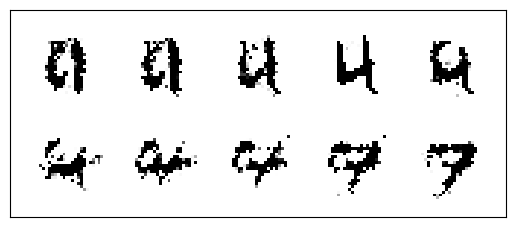

In [9]:
plot_interp(3, 11)

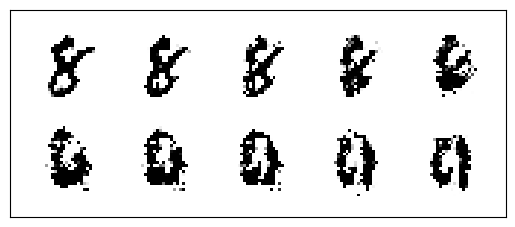

In [10]:
plot_interp(11, 22)

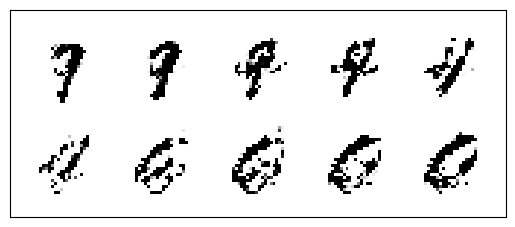

In [11]:
plot_interp(32, 334)

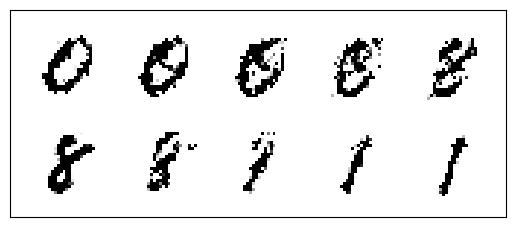

In [12]:
plot_interp(1, 2)

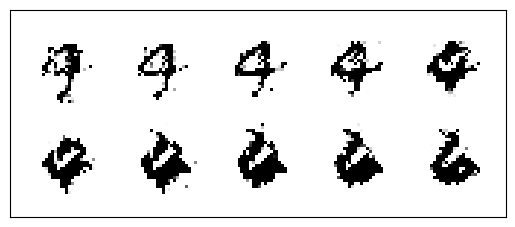

In [13]:
plot_interp(10, 12)

In [14]:
# Show decoder weights
first = decoder_params['params']['Dense_0']['kernel'].T
second = decoder_params['params']['Dense_1']['kernel'].T
third = decoder_params['params']['Dense_2']['kernel'].T

# Check rank of the decoder weights
print(np.linalg.matrix_rank(first))
print(np.linalg.matrix_rank(second))
print(np.linalg.matrix_rank(third))

4
100
100


Optimizing variational parameters...


  0%|          | 0/12000 [00:00<?, ?it/s]

Iteration 0: ELBO -158.51715087890625
Iteration 100: ELBO 187.37049865722656
Iteration 200: ELBO 195.1676788330078
Iteration 300: ELBO 197.45448303222656
Iteration 400: ELBO 199.1916046142578
Iteration 500: ELBO 200.5048828125
Iteration 600: ELBO 205.23410034179688
Iteration 700: ELBO 215.66212463378906
Iteration 800: ELBO 229.75115966796875
Iteration 900: ELBO 239.3950958251953
Iteration 1000: ELBO 247.7177734375
Iteration 1100: ELBO 259.7900390625
Iteration 1200: ELBO 271.056396484375
Iteration 1300: ELBO 284.5994567871094
Iteration 1400: ELBO 298.47149658203125
Iteration 1500: ELBO 312.6301574707031
Iteration 1600: ELBO 324.10552978515625
Iteration 1700: ELBO 332.4871826171875
Iteration 1800: ELBO 340.0450744628906
Iteration 1900: ELBO 345.87445068359375
Iteration 2000: ELBO 350.47125244140625
Iteration 2100: ELBO 353.8345947265625
Iteration 2200: ELBO 356.7130432128906
Iteration 2300: ELBO 359.0611877441406
Iteration 2400: ELBO 361.2581481933594
Iteration 2500: ELBO 362.92590332031

(np.float64(-2.052676868438721),
 np.float64(1.8935417652130127),
 np.float64(-1.8480246245861054),
 np.float64(1.734065192937851))

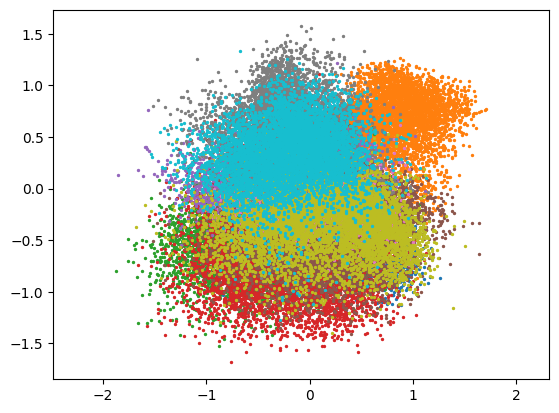

In [15]:
# Latent space is a vector, we need to reshape it to a 2D image and implement a convolutional decoder.

class ConvDecoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((-1, 2, 2, 1))
        x = nn.Conv(features=32, kernel_size=(7, 7), strides=(1, 1))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=64, kernel_size=(4, 4), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=128, kernel_size=(4, 4), strides=(2, 2))(x) # output shape of this layer is (4, 4, 1), need (28, 28, 1)
        x = nn.gelu(x)
        x = nn.Conv(features=784, kernel_size=(4, 4), strides=(1, 1))(x)
        x = x.reshape((-1, 28*28))
        return x


x_rand = random.normal(key, (32,data_dimension))
z_rand = random.normal(key, (32,latent_dimension,))
init_recognition_params = RecognitionNet().init(key, x_rand)
init_decoder_params = ConvDecoder().init(key, z_rand)

def log_likelihood(decoder_params, latent, datapoint):
    logits = ConvDecoder().apply(decoder_params, latent)
    return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
    return log_likelihood(decoder_params, latent, datapoint) + log_prior(latent)

params = (init_recognition_params, init_decoder_params)
opt_state = optimizer.init(params)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    params, opt_state = step(params, opt_state, t)
    callback(params, t)
    
recognition_params, decoder_params = params

for k in range(10):
    cur_data = train_images[train_labels[:, k] == True, :]
    latent_mean, _ = RecognitionNet().apply(recognition_params, cur_data)
    plt.scatter(latent_mean[:, 0], latent_mean[:, 1], s=2)

plt.axis("equal")


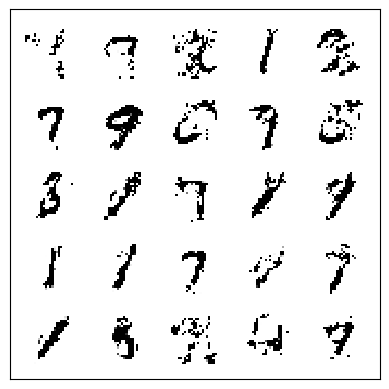

In [ ]:
# Sample data from the trained generative model to see if it roughly matches the data.

def sigmoid(x):
  return 0.5 * (np.tanh(x) + 1.0)

recognition_params, decoder_params = params
n_samples = 25
sampled_zs = jax.random.normal(key, shape=(n_samples,latent_dimension)) # sample from prior on z.

# calculate Jacobian of the ConvDecoder for each sample

def jacobian(f, x):
    return jax.jacfwd(f)(x)
                
jacobian_decoder = jacobian(ConvDecoder().apply, sampled_zs)

vdecoder = vmap(ConvDecoder().apply, in_axes=(None, 0))
bernoulli_means = sigmoid(vdecoder(decoder_params, sampled_zs)) # call decoder, and map logits to probabilities.
plot_images(bernoulli_means)

In [17]:
first_filter = decoder_params['params']['Conv_0']['kernel']
second_filter = decoder_params['params']['Conv_1']['kernel']
third_filter = decoder_params['params']['Conv_2']['kernel']
fourth_filter = decoder_params['params']['Conv_3']['kernel']

In [31]:
# check each filter rank for the convolutional decoder
for i in range(32):
    # check if full rank

    print(np.linalg.matrix_rank(first_filter[:,:,0,i]) ==7)

    print(np.linalg.matrix_rank(first_filter[:,:,0,i]))

for i in range(64):
    # check if full rank
    for j in range(32):
        print(np.linalg.matrix_rank(second_filter[:,:,j,i]) ==4)
        print(np.linalg.matrix_rank(second_filter[:,:,j,i]))

for i in range(128):
    # check if full rank
    for j in range(64):
        print(np.linalg.matrix_rank(third_filter[:,:,j,i]) ==4)
        print(np.linalg.matrix_rank(third_filter[:,:,j,i]))
        

True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
7
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4
True
4

In [21]:
# test if the first_filter is invertible
# Calculate dft of all 7x7 filters anc see if they have zeros
# first filter is 7x7x2x32, so there are 32 7x7 filters 
dft_filters = np.fft.fft2(fourth_filter, axes=(0, 1))
dft_filters = np.abs(dft_filters)
print(dft_filters.shape)

# Check if there are zeros in the dft of the filters
print(np.any(dft_filters < 1e-7))




(4, 4, 128, 784)
False
